# Computing behavioural syllables using `keypoint-moseq`

In this notebook, we will explore possible simple analyses we can carry out with a trained `keypoint-moseq` model applied to new data.
Using a trained model is useful if you have collected data for new experiments but would like to maintain an existing set of syllables. 

We assume that you have gone through the `EPM_train_keypoint_moseq.ipynb` notebook, that explains how to create and train a `keypoint-moseq` model on a set of 10 videos. We also assumed you have downloaded the `mouse-EPM` folder containing the sample data.

This notebook is based on the [one](https://github.com/dattalab/keypoint-moseq/blob/main/docs/keypoint_moseq_colab.ipynb) provided as part of the `keypoint-moseq` documentation.  

## A. Setup
### A1. Create a conda environment and install the required packages
In this notebook, we will use the conda environment defined in the `keypoint-moseq` repository, with an optional additional package.

In a terminal, clone the `keypoint-moseq` repository (ideally somewhere outside the `course-behavioural-analysis` repository):
```bash
git clone https://github.com/dattalab/keypoint-moseq
cd keypoint-moseq
```

Then, create the appropriate conda environment for your platform. For example, for a Linux installation with a GPU we would run:
```bash
# Linux (GPU)
conda env create -f conda_envs/environment.linux_gpu.yml
``` 
For other platforms, please the full list of commands in the [keypoint-moseq docs](https://keypoint-moseq.readthedocs.io/en/latest/install.html#install-using-conda).


This last command will create a conda environment called `keypoint_moseq`. We can activate this environment by running:
```bash
conda activate keypoint-moseq
```

Optionally, for interacting with plots in the notebook, we can install the `ipympl` package in the `keypoint-moseq` environment:
```bash
pip install ipympl 
```

Once all requirements are installed, you can re-open this notebook and select the `keypoint-moseq` kernel.

### A2. Import required packages

In [1]:
import itertools
import keypoint_moseq as kpms
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

/home/sminano/miniconda3/envs/keypoint_moseq/lib/python3.9/site-packages/keypoint_moseq/analysis.py:20: UserWarning:

Using Panel interactively in VSCode notebooks requires the jupyter_bokeh package to be installed. You can install it with:

   pip install jupyter_bokeh

or:
    conda install jupyter_bokeh

and try again.



In [2]:
# To use interactive plots, uncomment the following line and run this cell (optional)
%matplotlib widget

### A3. Specify paths to trained model and new data

You should modify `DATA_DIR` to point to the directory where you downloaded the `mouse-EPM` folder containing the sample data.

In [3]:
DATA_DIR = Path.home() / 'swc' / 'project_teaching_behaviour' / 'mouse-EPM'

# path to new data (DLC predictions for video-1)
filename = "sub-01_ses-01_task-EPM_time-165049_video_DLC_resnet50_MouseTopDownSep13shuffle1_340000.h5"
filename_no_ext = Path(filename).stem
file_path = DATA_DIR / "derivatives" / "software-DLC_predictions" / filename 

# path to kpt-moseq trained model
project_dir = DATA_DIR / "derivatives" / "software-kptmoseq_n-10_project"
model_name = '2024_09_19-15_54_42'

## B. Apply trained model to new SLEAP predictions

Load the trained model and config

In [4]:
# load model
model, data, metadata, current_iter = kpms.load_checkpoint(project_dir, model_name)

# load config 
config = kpms.load_config(project_dir)  # noqa: E731

In [5]:
# print config
for k,v in config.items():
    print(f"{k}: {v}")

bodyparts: ['snout', 'left_ear', 'right_ear', 'centre', 'lateral_left', 'lateral_right', 'tailbase', 'tail_end']
use_bodyparts: ['snout', 'left_ear', 'right_ear', 'centre', 'lateral_left', 'lateral_right', 'tailbase']
skeleton: [['snout', 'left_ear'], ['snout', 'right_ear'], ['snout', 'centre'], ['centre', 'lateral_left'], ['centre', 'lateral_right'], ['centre', 'tailbase'], ['tailbase', 'lateral_left'], ['tailbase', 'lateral_right']]
anterior_bodyparts: ['snout']
posterior_bodyparts: ['tailbase']
added_noise_level: 0.1
PCA_fitting_num_frames: 1000000
conf_threshold: 0.6
error_estimator: {'intercept': 0.8, 'slope': -0.6}
obs_hypparams: {'nu_s': 5, 'nu_sigma': 100000.0, 'sigmasq_0': 0.1, 'sigmasq_C': 0.1}
ar_hypparams: {'K_0_scale': 10.0, 'S_0_scale': 0.01, 'latent_dim': 7, 'nlags': 3}
trans_hypparams: {'alpha': 5.7, 'gamma': 1000.0, 'kappa': 1000000.0, 'num_states': 100}
cen_hypparams: {'sigmasq_loc': 0.5}
recording_name_suffix: 
verbose: False
conf_pseudocount: 0.001
video_dir: /media

Parse the new keypoint data and format it for the model

In [8]:
# parse keypoint data
coordinates, confidences, bodyparts = kpms.load_keypoints(str(file_path), "deeplabcut")

# - coordinates: for each video, an array of size (nframes, n_kpts, n_spatial_dims) with the coords of the keypoints in image coord system
# - confidences: for each video, an array of size (nframes, n_kpts)
print(coordinates.keys())
print(coordinates[filename_no_ext].shape)

print(bodyparts)

Loading keypoints: 100%|█████████████████| 1/1 [00:00<00:00, 224.92it/s]

dict_keys(['sub-01_ses-01_task-EPM_time-165049_video_DLC_resnet50_MouseTopDownSep13shuffle1_340000'])
(18485, 8, 2)
['snout', 'left_ear', 'right_ear', 'centre', 'lateral_left', 'lateral_right', 'tailbase', 'tail_end']


In [9]:
# format data for model
data, metadata = kpms.format_data(coordinates, confidences, **config)

Apply the trained model to the new data

In [10]:
# in theory: The results for the new
# experiments will be added to the existing `results.h5` file. ---- CHECK


# apply trained model to new data
# extracts results to variable and h5 file
results = kpms.apply_model(
    model, 
    data, 
    metadata, 
    project_dir, 
    model_name, 
    **config, 
    results_path=(
        '/home/sminano/swc/project_teaching_behaviour/mouse-EPM/derivatives/software-kptmoseq_n-10_project/2024_09_19-15_54_42/'
        'results_video-1.h5'
    )  # ----> otherwise it overwrites results.h5 file!
)  

# optionally rerun `save_results_as_csv` to export the new results as a csv
kpms.save_results_as_csv(results, project_dir, model_name)

Applying model: 100%|█████████████████| 500/500 [08:37<00:00,  1.03s/it]


Saved results to /home/sminano/swc/project_teaching_behaviour/mouse-
EPM/derivatives/software-
kptmoseq_n-10_project/2024_09_19-15_54_42/results_video-1.h5


Saving to csv: 100%|██████████████████████| 1/1 [00:00<00:00, 23.48it/s]


Inspect results

In [12]:
print(results.keys())
print(results[filename_no_ext].keys())

dict_keys(['sub-01_ses-01_task-EPM_time-165049_video_DLC_resnet50_MouseTopDownSep13shuffle1_340000'])
dict_keys(['syllable', 'latent_state', 'centroid', 'heading'])


## C. Compute frequency of syllables in the new data

In [17]:
# extract array with the syllable assign to every frame
syllables_per_frame = results[filename_no_ext]["syllable"]  
print(syllables_per_frame.shape) # size of array: (nframes, )

# count the number of times each syllable appears in the video
syllables_count = {}
for syl in np.unique(syllables_per_frame):
    syllables_count[syl] = sum(syl == syllables_per_frame)

# sort syllables by count
syllables_count = dict(
    sorted(
        syllables_count.items(), 
        key=lambda item: item[1], 
        reverse=True
    )
)

# print top 10
# (the syllable IDs are assigned based on their frequency in the training data)
n_frames = results[filename_no_ext]["syllable"].shape[0]
for syl, count in list(syllables_count.items())[:10]:
    print(f"Syllable id-{syl}: {(count/n_frames)*100:.2f} % of frames")

(18485,)
Syllable id-2: 44.35 % of frames
Syllable id-0: 24.80 % of frames
Syllable id-3: 15.51 % of frames
Syllable id-5: 9.10 % of frames
Syllable id-1: 4.08 % of frames
Syllable id-4: 0.95 % of frames
Syllable id-6: 0.60 % of frames
Syllable id-7: 0.21 % of frames
Syllable id-10: 0.14 % of frames
Syllable id-9: 0.12 % of frames


## D. Plot ethogram for new data (first 1000 frames)

In [21]:
# Find continuous chunks of frames with the same syllable
# itertools.groupby: generates a break or new group
# every time the value of the key function changes
syllable_chunks = [
    (key, len(list(group_iter)))
    for key, group_iter in itertools.groupby(syllables_per_frame)
]  # list of tuples, each tuple is a pair (syllable_id, lenght_of_chunk)

chunks_duration = [syl_dur for syl_id, syl_dur in syllable_chunks]
chunks_start = np.cumsum([0]+chunks_duration) - 0.5 # starting frame of each chunk

Text(0.5, 1.0, 'sub-01_ses-01_task-EPM_time-165049_video_DLC_resnet50_MouseTopDownSep13shuffle1_340000')

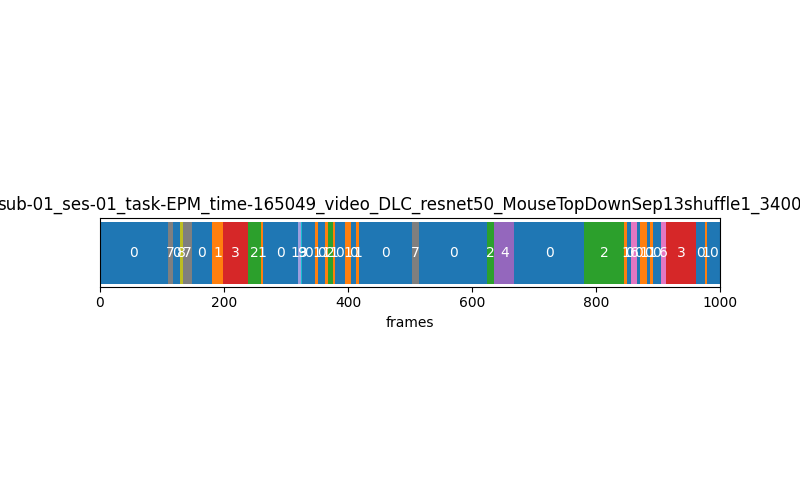

In [22]:
# prepare colormap for syllables
list_colors = (
    plt.get_cmap("tab10").colors
    + plt.get_cmap("tab20b").colors
    + plt.get_cmap("Set3").colors
    + plt.get_cmap("Set1").colors
)  # 51 colors

# select maximum frames to plot
frames_max_to_plot = 1000

fig, ax = plt.subplots(1, 1, figsize=(8,5))
rects = ax.barh(
    y=results.keys(),
    width=chunks_duration,
    left=chunks_start[:-1],  
    height=1,
    color=[
        list_colors[syl_id%len(list_colors)] 
        for syl_id, syl_dur in syllable_chunks
    ],
)
ax.bar_label(
    rects, 
    labels=[syl_id for syl_id, syl_dur in syllable_chunks],
    label_type='center', 
    color='white'
)
ax.set_xlim(0, frames_max_to_plot)
ax.set_xlabel('frames')
ax.yaxis.set_visible(False)

ax.set_aspect(100)
ax.set_title(*results.keys())

## E. Compute median duration per syllable and plot

In [27]:
# compute median syllable duration
median_syllable_duration = np.median(chunks_duration)
print(f'The median syllable duration is {median_syllable_duration} frames')
print('----')

# compute median duration per syllable ID
median_duration_per_syl = {}
for syl in list(syllables_count.keys()):
    median_duration_per_syl[syl] = np.median(
        [
            syl_dur 
            for (syl_id, syl_dur) in syllable_chunks 
            if syl_id == syl
        ]
    )  

for k,v in median_duration_per_syl.items():
    print(f"The median duration for syllable-id {k} is {v} frames")


The median syllable duration is 18.0 frames
----
The median duration for syllable-id 2 is 58.5 frames
The median duration for syllable-id 0 is 21.0 frames
The median duration for syllable-id 3 is 46.0 frames
The median duration for syllable-id 5 is 86.5 frames
The median duration for syllable-id 1 is 4.0 frames
The median duration for syllable-id 4 is 13.5 frames
The median duration for syllable-id 6 is 4.0 frames
The median duration for syllable-id 7 is 10.0 frames
The median duration for syllable-id 10 is 6.0 frames
The median duration for syllable-id 9 is 4.0 frames
The median duration for syllable-id 8 is 3.5 frames
The median duration for syllable-id 13 is 4.5 frames


Median syllable duration (frames): 18.0
Median syllable duration (ms): 600.0


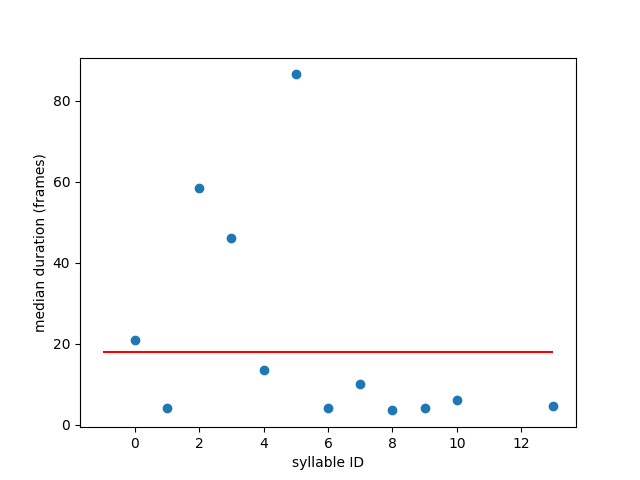

In [28]:
# plot median duration per syllable
fps = 30 

fig, ax = plt.subplots(1, 1)
ax.scatter(
    x=median_duration_per_syl.keys(),
    y=median_duration_per_syl.values(),
)
ax.hlines(
    y=median_syllable_duration,
    xmin=-1,
    xmax=len(median_duration_per_syl) + 1,
    colors="r",
)
ax.set_xlabel("syllable ID")
ax.set_ylabel("median duration (frames)")

print(f"Median syllable duration (frames): {median_syllable_duration}")
print(f"Median syllable duration (ms): {1000*median_syllable_duration/fps}")

## F. Visualise the most frequent syllables in the new data

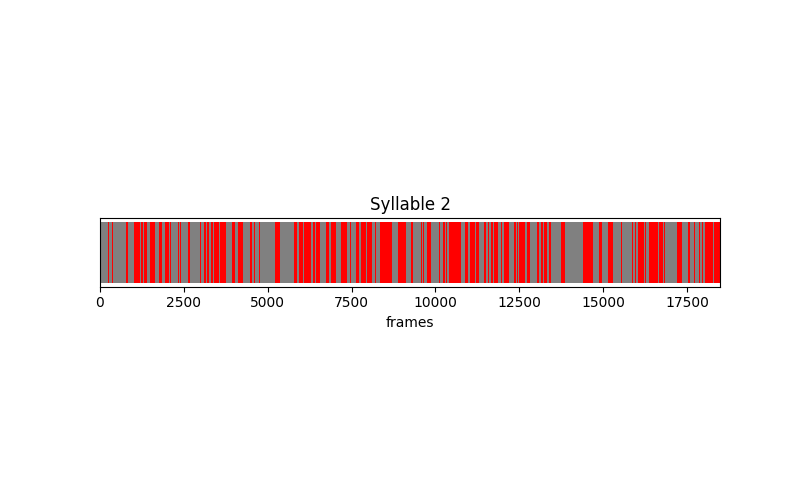

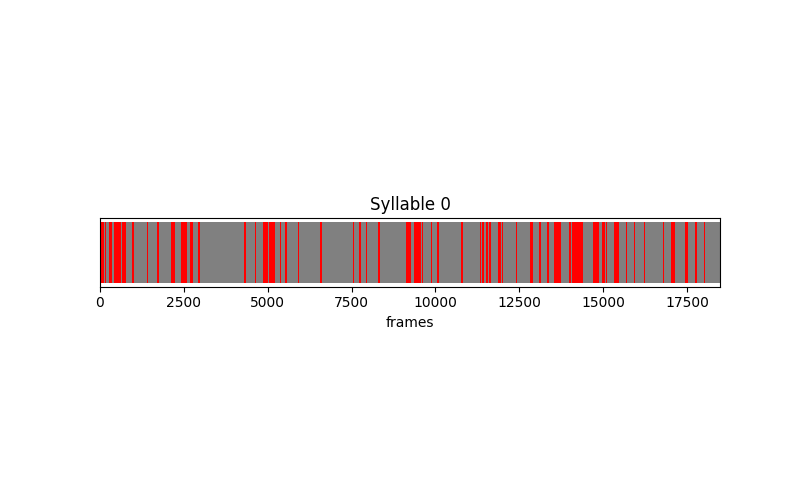

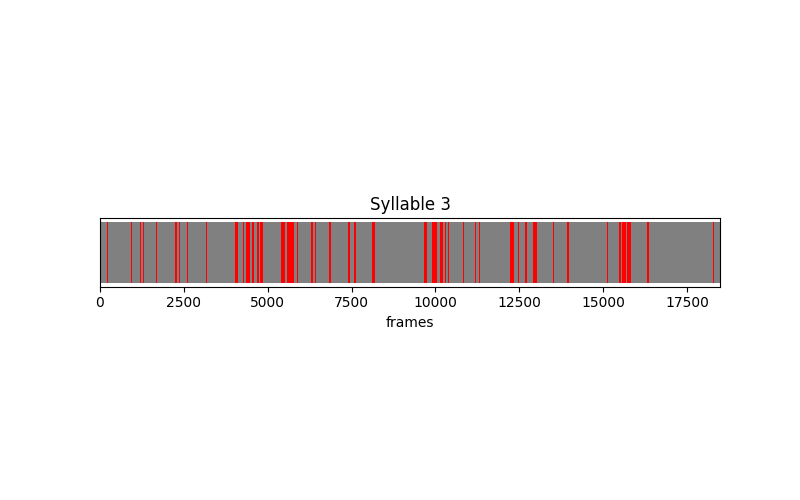

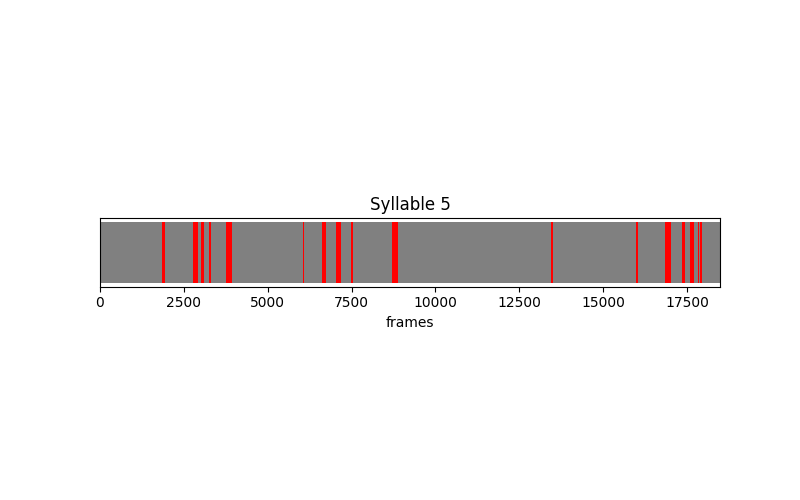

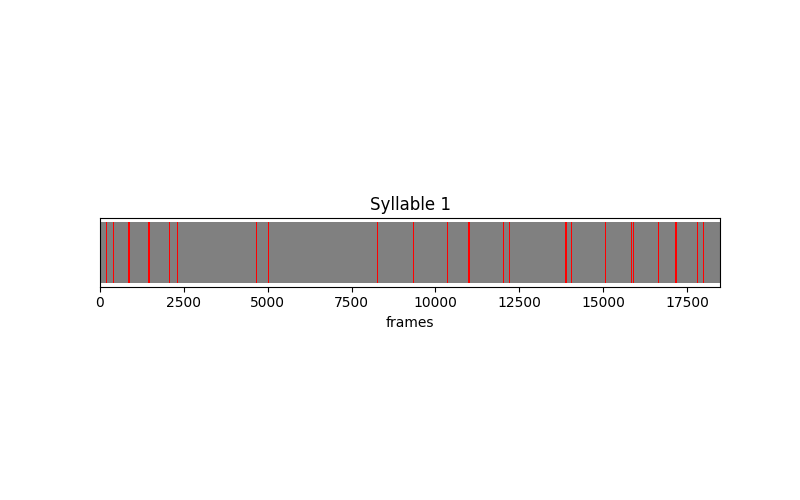

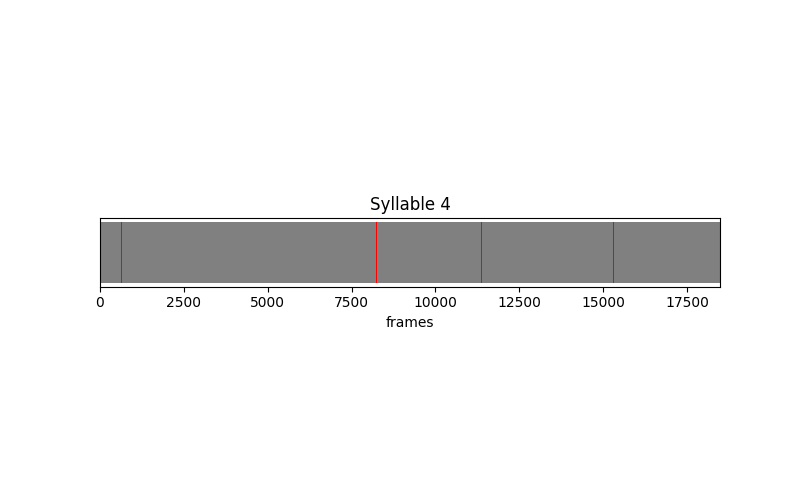

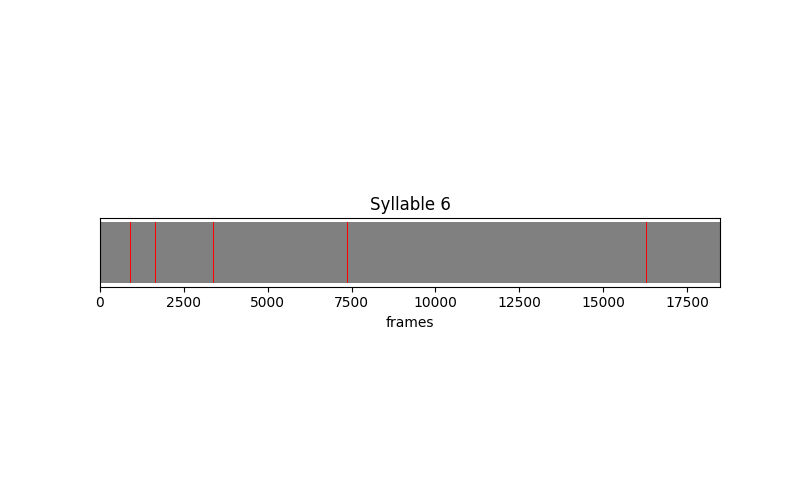

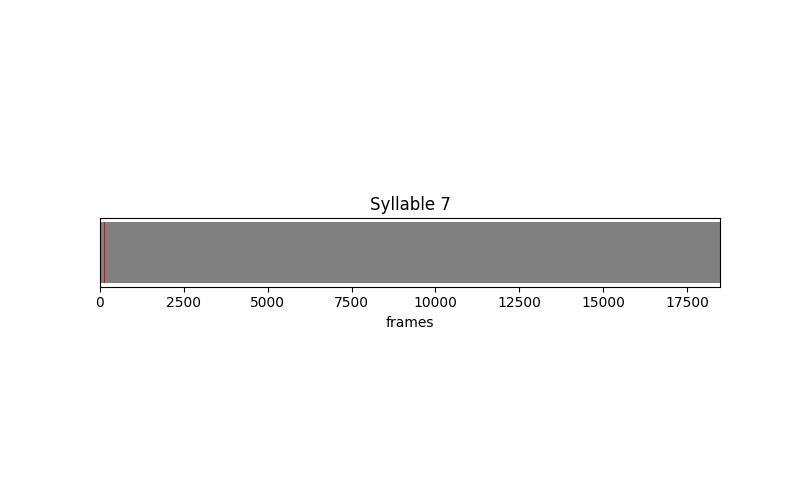

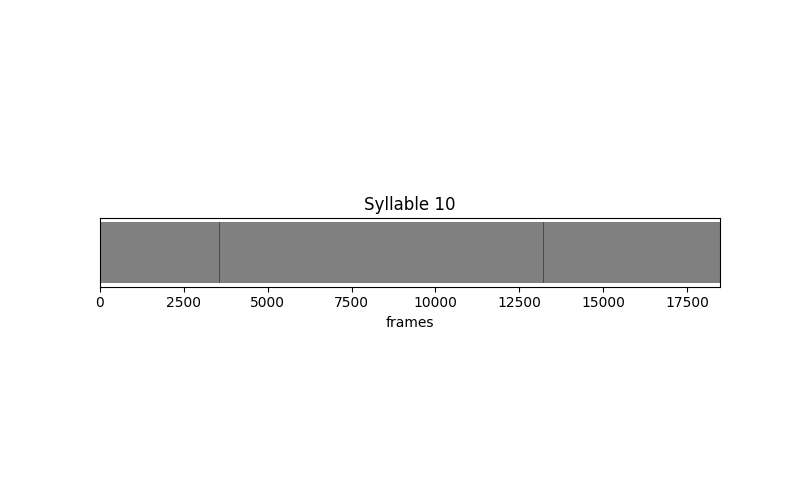

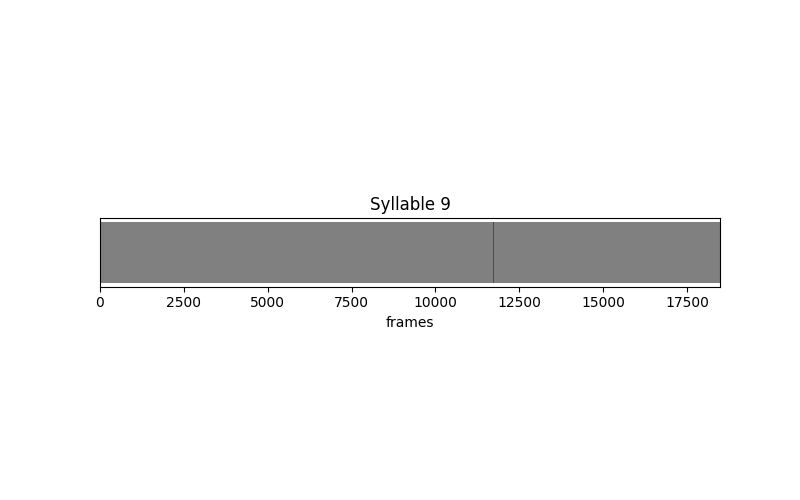

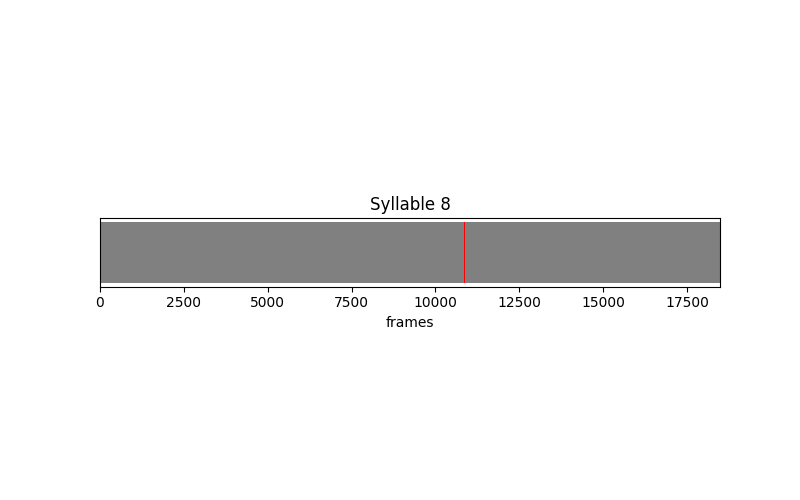

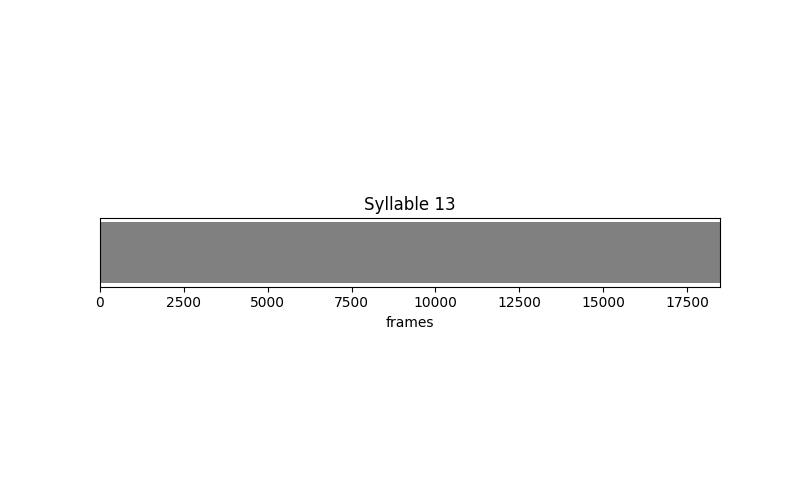

In [45]:
frames_max_to_plot = len(syllables_per_frame)
list_syllables_to_plot = syllables_count.keys()

# fig, axs = plt.subplots(
#     len(list_syllables_to_plot), 1, 
#     figsize=(8,5),
#     sharex=True
# )
# for i, selected_syl in enumerate(list_syllables_to_plot):

    
#     rects = axs[i].barh(
#         y=results.keys(),
#         width=[syl_dur for syl_id, syl_dur in syllable_chunks],
#         left=chunks_start[:-1],  # starting frame of each chunk
#         height=1,
#         color=[
#             'red' if syl_id==selected_syl 
#             else 'grey' 
#             for syl_id, _ in syllable_chunks
#         ],
#     )
#     axs[i].set_xlim(0, frames_max_to_plot)
#     axs[i].set_xlabel('frames')
#     axs[i].yaxis.set_visible(False)

#     axs[i].set_aspect(int(frames_max_to_plot/10))
#     axs[i].set_title(f'Syllable {selected_syl}')

# fig.subplots_adjust(hspace=1)

for selected_syl in list_syllables_to_plot:

    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    rects = ax.barh(
        y=results.keys(),
        width=[syl_dur for syl_id, syl_dur in syllable_chunks],
        left=chunks_start[:-1],  # starting frame of each chunk
        height=1,
        color=[
            'red' if syl_id==selected_syl 
            else 'grey' 
            for syl_id, _ in syllable_chunks
        ],
    )
    # ax.bar_label(rects, label_type='center', color='white')
    ax.set_xlim(0, frames_max_to_plot)
    ax.set_xlabel('frames')
    ax.yaxis.set_visible(False)

    ax.set_aspect(int(frames_max_to_plot/10))
    ax.set_title(f'Syllable {selected_syl}')

## G. Plot centroid location for the top three syllables

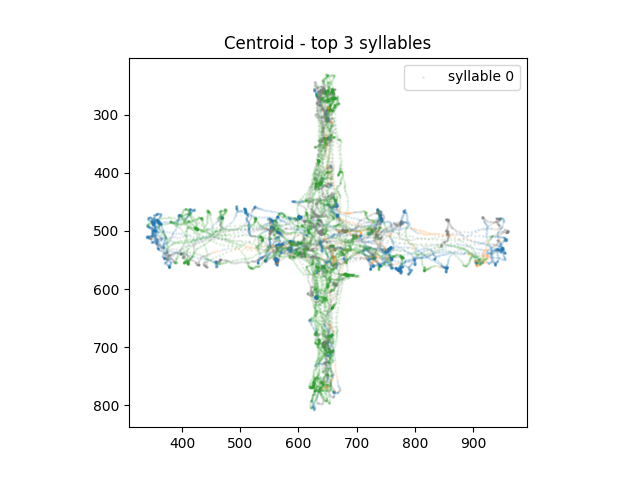

In [66]:
fig, ax = plt.subplots(1,1)
top_k_syllables = 3

centroid_array = results[filename_no_ext]['centroid']
syllable_array = results[filename_no_ext]['syllable']

# if syllable not in top-k set, plot trajectory in grey
ax.scatter(
    x=centroid_array[:,0],
    y=centroid_array[:,1],
    s=1,
    c=[
        list_colors[int(syl_id)%len(list_colors)] + (0.1,)
        if syl_id in list(range(top_k_syllables)) else (0.5, 0.5, 0.5, 0.1)
        for syl_id in syllable_array
    ],
)
ax.legend([f'syllable {syl}' for syl in list(range(top_k_syllables))])
ax.set_title(f'Centroid - top {top_k_syllables} syllables')
ax.invert_yaxis()
ax.set_aspect('equal')

In [52]:
centroid_array[syllable_array == 3]

array([[726.51582436, 494.79575225],
       [728.53085719, 493.53663656],
       [730.65774502, 492.67348316],
       ...,
       [628.62534566, 355.60531483],
       [628.04012803, 356.51153868],
       [628.42767705, 356.42365572]])

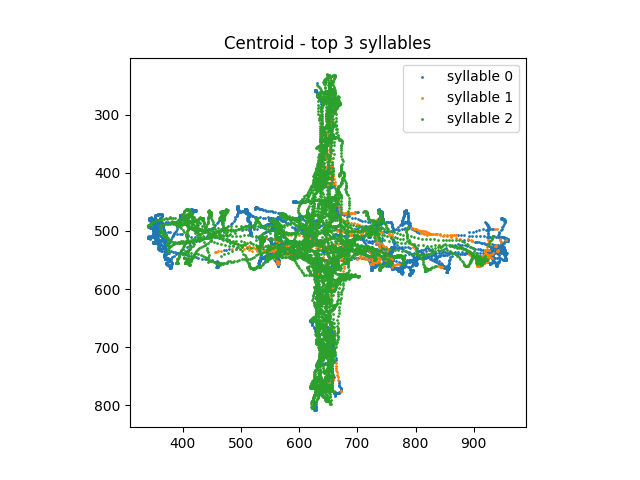

In [64]:
fig, ax = plt.subplots(1,1)
top_k_syllables = 3

centroid_array = results[filename_no_ext]['centroid']
syllable_array = results[filename_no_ext]['syllable']

# if syllable not in top-k set, plot trajectory in grey
for syl_id in range(top_k_syllables):

    ax.scatter(
        x=centroid_array[syllable_array == syl_id,0],
        y=centroid_array[syllable_array == syl_id,1],
        s=1,
        color=list_colors[int(syl_id)%len(list_colors)]
    )
                      
ax.legend([f'syllable {syl}' for syl in list(range(top_k_syllables))])
ax.set_title(f'Centroid - top {top_k_syllables} syllables')
ax.invert_yaxis()
ax.set_aspect('equal')

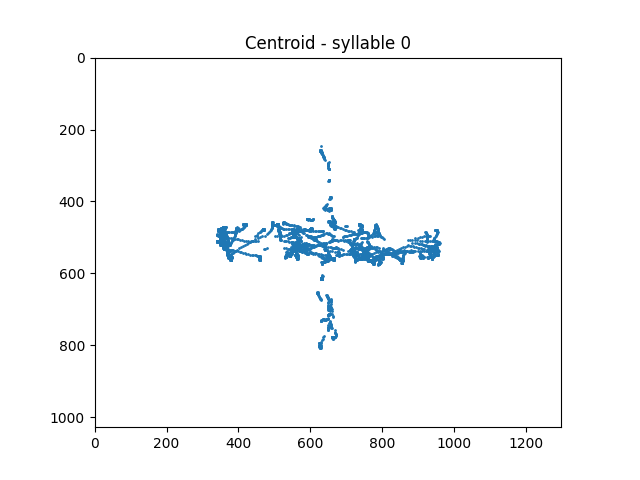

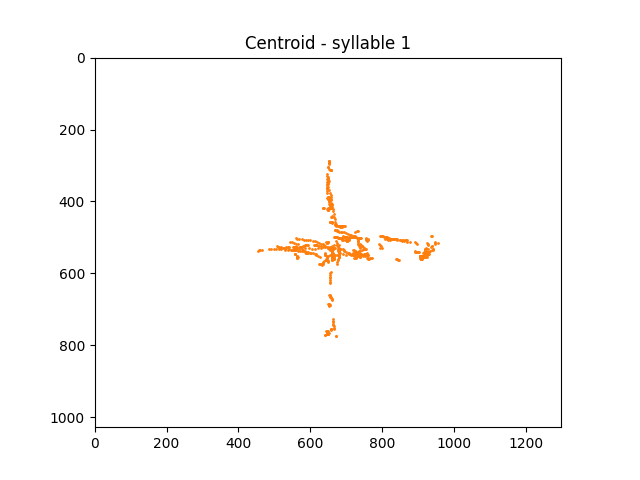

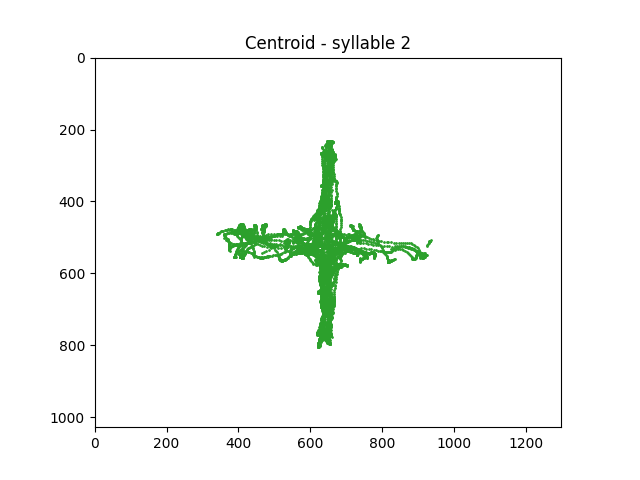

In [75]:
# fig, ax = plt.subplots(1,1)
top_k_syllables = 3

centroid_array = results[filename_no_ext]['centroid']
syllable_array = results[filename_no_ext]['syllable']

# if syllable not in top-k set, plot trajectory in grey
for syl_id in range(top_k_syllables):

    fig, ax = plt.subplots(1,1)
    ax.scatter(
        x=centroid_array[syllable_array == syl_id,0],
        y=centroid_array[syllable_array == syl_id,1],
        s=1,
        color=list_colors[int(syl_id)%len(list_colors)]
    )

    ax.set_title(f'Centroid - syllable {syl_id}')

    # image size: 1298 × 1028
    ax.set_xlim([0, 1298])
    ax.set_ylim([0, 1028])
    ax.invert_yaxis()
    ax.set_aspect('equal')


In [77]:
np.arange(-0.5, 1298, 1)

array([-5.0000e-01,  5.0000e-01,  1.5000e+00, ...,  1.2955e+03,
        1.2965e+03,  1.2975e+03])

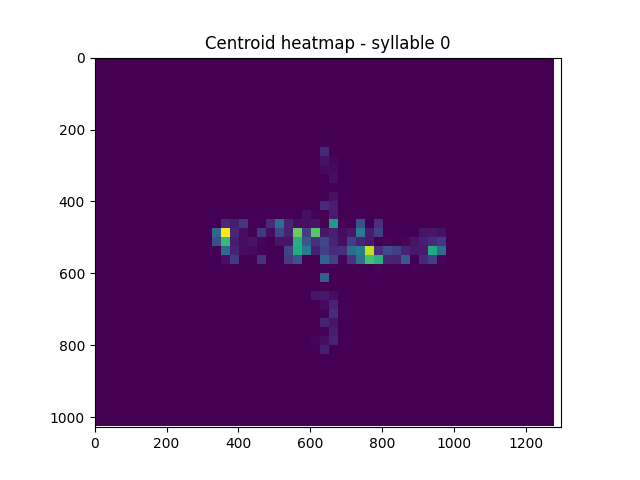

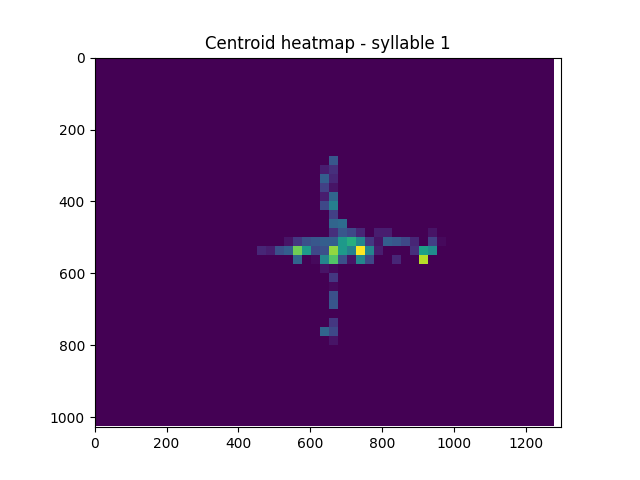

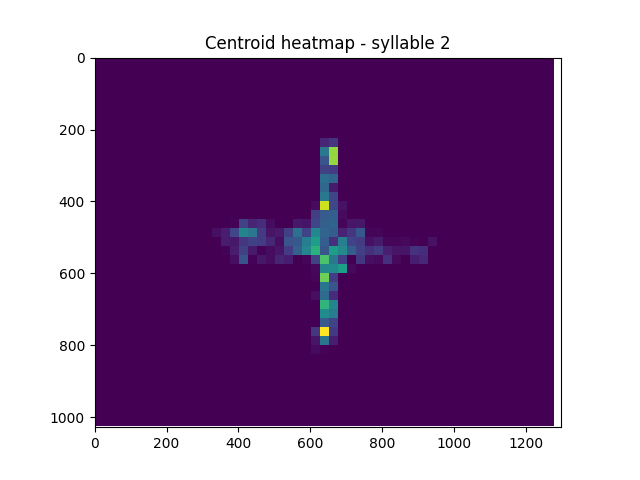

In [84]:
# heatmaps for top-k syllables
# assuming DLC trajectories are in an image cooordinate system with the origin 
# at the centre of the top-left pixel
# (this is the case for [SLEAP](https://github.com/talmolab/sleap/discussions/1640#discussioncomment-7867277) and for opencv)
top_k_syllables = 3

centroid_array = results[filename_no_ext]['centroid']
syllable_array = results[filename_no_ext]['syllable']


for syl_id in range(top_k_syllables):
    fig, ax = plt.subplots(1,1)

    # image size: 1298 × 1028
    bin_width = 25 # in pixels
    x_edges_in = np.arange(-0.5, 1298, bin_width)
    y_edges_in = np.arange(-0.5, 1028, bin_width)

    heatmap, xedges, yedges = np.histogram2d(
        x=centroid_array[syllable_array == syl_id,0],
        y=centroid_array[syllable_array == syl_id,1],
        bins=[x_edges_in, y_edges_in] # xedges = yedges
    )
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    ax.imshow(heatmap.T, extent=extent, origin='lower')

    ax.set_title(f'Centroid heatmap - syllable {syl_id}')

    
    ax.set_xlim([0, 1298])
    ax.set_ylim([0, 1028])
    ax.invert_yaxis()
    ax.set_aspect('equal')


## Appendix

The results in the .h5 file follow the structure below. 
```
    results.h5
    ├──recording_name1
    │  ├──syllable      # syllable labels (z)
    │  ├──latent_state  # inferred low-dim pose state (x)
    │  ├──centroid      # inferred centroid (v)
    │  └──heading       # inferred heading (h)
    ⋮
```

They can be reloaded at a later time using `kpms.load_results`.

Check the docs for an [in-depth explanation of the modeling results](https://keypoint-moseq.readthedocs.io/en/latest/FAQs.html#interpreting-model-outputs).